# Data Pattern Analysis for Test Case Creation

This notebook analyzes patterns in your dataset to inform the creation of representative test cases for embedding evaluation.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import json
import yaml

sns.set_theme() 
sns.set_palette("husl")

In [20]:
# Load your dataset
data_path = Path("./data/processed_dataset.csv")
df = pd.read_csv(data_path)

# Load config to get column mappings
config_path = Path("./config/embedding_eval.yaml")
with open(config_path) as f:
    config = yaml.safe_load(f)

# Get column names from config
content_col = config['dataset']['columns']['content']
identifier_col = config['dataset']['columns']['identifier']
metadata_col = config['dataset']['columns']['metadata']

print(f"Dataset shape: {df.shape}")
print("\nColumns:", df.columns.tolist())

Dataset shape: (12340, 9)

Columns: ['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot', 'PlotSummary']


## 1. Content Length Analysis

Content Length Statistics:
count    12340.000000
mean       407.403728
std         98.357830
min        194.000000
25%        329.000000
50%        396.000000
75%        485.000000
max        697.000000
Name: content_length, dtype: float64

Word Count Statistics:
count    12340.000000
mean        69.048136
std         16.719186
min         32.000000
25%         56.000000
50%         67.000000
75%         82.000000
max        115.000000
Name: word_count, dtype: float64


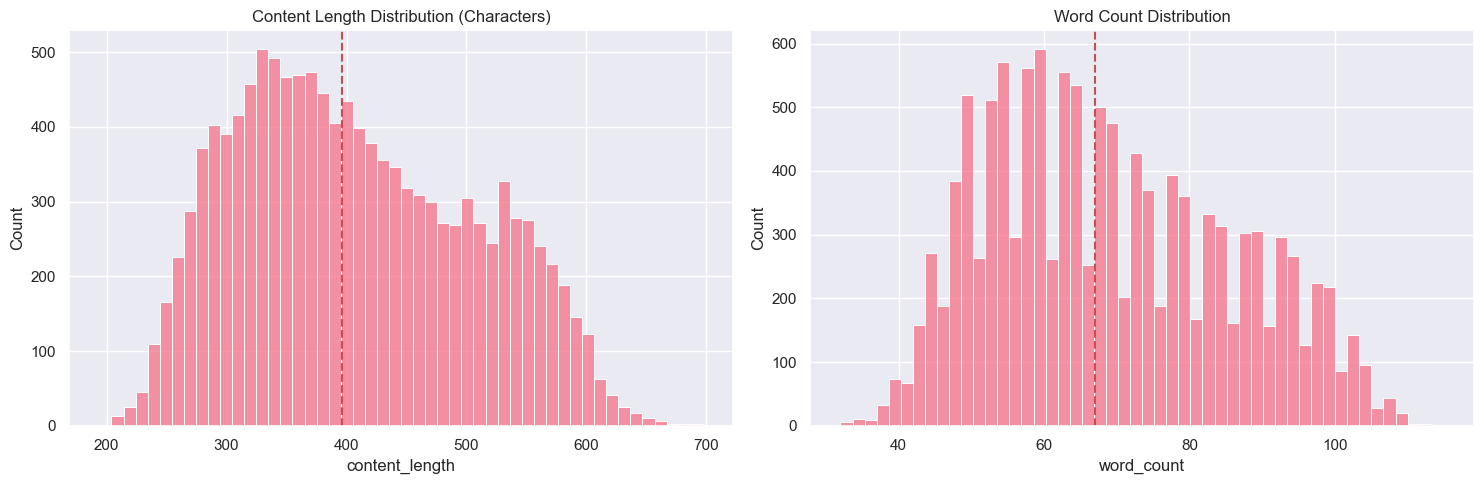

In [21]:
# Analyze content lengths
df['content_length'] = df[content_col].str.len()
df['word_count'] = df[content_col].str.split().str.len()

# Plot length distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
sns.histplot(data=df, x='content_length', bins=50, ax=ax1)
ax1.set_title('Content Length Distribution (Characters)')
ax1.axvline(df['content_length'].median(), color='r', linestyle='--', label='Median')

# Word count distribution
sns.histplot(data=df, x='word_count', bins=50, ax=ax2)
ax2.set_title('Word Count Distribution')
ax2.axvline(df['word_count'].median(), color='r', linestyle='--', label='Median')

plt.tight_layout()

# Print statistics
print("Content Length Statistics:")
print(df['content_length'].describe())
print("\nWord Count Statistics:")
print(df['word_count'].describe())

## 2. Metadata Analysis

Metadata Distribution:
Genre
drama              18.922204
comedy             17.423015
horror              5.786062
western             4.546191
action              3.889789
thriller            3.654781
crime drama         2.909238
science fiction     2.755267
unknown             2.714749
adventure           2.423015
romantic comedy     1.782820
animation           1.750405
musical             1.515397
film noir           1.458671
sci-fi              1.442464
Name: count, dtype: float64


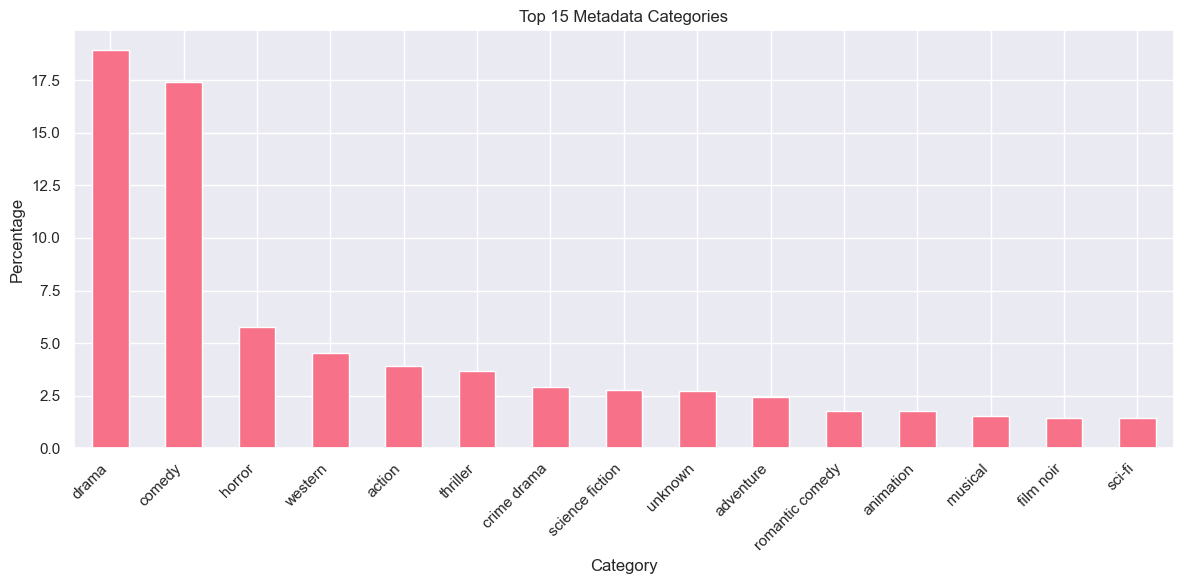

In [22]:
# Analyze metadata distribution
metadata_counts = df[metadata_col].value_counts()
metadata_pcts = metadata_counts / len(df) * 100

# Plot top metadata categories
plt.figure(figsize=(12, 6))
metadata_pcts.head(15).plot(kind='bar')
plt.title('Top 15 Metadata Categories')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

print("Metadata Distribution:")
print(metadata_pcts.head(15))

## 3. Content Pattern Analysis

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Analyze common phrases
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df[content_col])

# Get most common phrases
feature_names = vectorizer.get_feature_names_out()
freqs = X.sum(axis=0).A1
common_phrases = pd.Series(
    freqs, 
    index=feature_names
).sort_values(ascending=False)

print("Most Common Phrases:")
print(common_phrases.head(20))

Most Common Phrases:
new york         843
year old         661
new york city    430
york city        430
los angeles      429
high school      414
years later      304
united states    250
best friend      230
world war        218
falls love       194
young woman      162
film opens       151
world war ii     149
war ii           149
film stars       148
film set         147
man named        140
small town       140
san francisco    137
dtype: int64


## 4. Generate Test Case Recommendations

In [24]:
def generate_test_recommendations(df, content_col, metadata_col):
    """Generate test case recommendations based on data patterns."""
    recommendations = {
        "content_length_categories": {
            "short": int(df['content_length'].quantile(0.25)),
            "medium": int(df['content_length'].quantile(0.5)),
            "long": int(df['content_length'].quantile(0.75))
        },
        "metadata_coverage": {
            category: float(pct)
            for category, pct in metadata_pcts.head(5).items()
        },
        "sample_sizes": {
            "recommended_test_cases": min(int(len(df) * 0.01), 100),
            "min_per_category": max(int(len(df) * 0.001), 5)
        },
        "example_cases": [
            {
                "type": "length_based",
                "examples": {
                    length: df[df['content_length'] <= threshold][content_col].iloc[0]
                    for length, threshold in zip(
                        ["short", "medium", "long"],
                        [df['content_length'].quantile(q) for q in [0.25, 0.5, 0.75]]
                    )
                }
            },
            {
                "type": "metadata_based",
                "examples": {
                    category: df[df[metadata_col] == category][content_col].iloc[0]
                    for category in metadata_pcts.head(3).index
                }
            }
        ]
    }
    
    return recommendations

recommendations = generate_test_recommendations(df, content_col, metadata_col)

# Save recommendations
output_path = Path("./config/test_recommendations.json")
with open(output_path, 'w') as f:
    json.dump(recommendations, f, indent=2)

print("Test Case Recommendations:")
print(json.dumps(recommendations, indent=2))

Test Case Recommendations:
{
  "content_length_categories": {
    "short": 329,
    "medium": 396,
    "long": 485
  },
  "metadata_coverage": {
    "drama": 18.92220421393841,
    "comedy": 17.423014586709886,
    "horror": 5.786061588330632,
    "western": 4.546191247974067,
    "action": 3.889789303079417
  },
  "sample_sizes": {
    "recommended_test_cases": 100,
    "min_per_category": 12
  },
  "example_cases": [
    {
      "type": "length_based",
      "examples": {
        "short": "Mal Granger (Edmond O'Brien) is a telephone repairman who likes to bet on the horses. He takes control of the wire service, making him a target for the Los Angeles Police. East Coast mobster Larry Mason (Don Porter) is sent by boss Carl Stephans (Otto Kruger) to persuade Granger to join the Syndicate.",
        "medium": "Mal Granger (Edmond O'Brien) is a telephone repairman who likes to bet on the horses. He takes control of the wire service, making him a target for the Los Angeles Police. East Co

## 5. Suggested Test Case Distribution

In [25]:
def suggest_test_distribution():
    """Suggest how to distribute test cases based on data patterns."""
    suggestions = {
        "by_length": {
            "short": 0.3,   # 30% short content
            "medium": 0.4,  # 40% medium content
            "long": 0.3     # 30% long content
        },
        "by_metadata": {
            "top_categories": 0.6,      # 60% from top categories
            "middle_categories": 0.3,   # 30% from middle categories
            "rare_categories": 0.1      # 10% from rare categories
        },
        "similarity_levels": {
            "high": 0.3,    # 30% high similarity pairs
            "medium": 0.4,  # 40% medium similarity pairs
            "low": 0.3      # 30% low similarity pairs
        }
    }
    
    return suggestions

distribution = suggest_test_distribution()
print("Suggested Test Case Distribution:")
print(json.dumps(distribution, indent=2))

Suggested Test Case Distribution:
{
  "by_length": {
    "short": 0.3,
    "medium": 0.4,
    "long": 0.3
  },
  "by_metadata": {
    "top_categories": 0.6,
    "middle_categories": 0.3,
    "rare_categories": 0.1
  },
  "similarity_levels": {
    "high": 0.3,
    "medium": 0.4,
    "low": 0.3
  }
}
